## Import Thư viện

In [1344]:
import pandas as pd
from category_encoders import BinaryEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,accuracy_score,accuracy_score,recall_score,f1_score,precision_score,confusion_matrix
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import Normalizer, MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler, \
    PowerTransformer, QuantileTransformer,LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud as WordCloud
import numpy as np
from collections import Counter
from datetime import datetime
from scipy.stats import uniform

import warnings
warnings.filterwarnings('ignore')

## Mã hóa dữ liệu

In [1345]:
# def binary_encoder(df, var):
#     encoder = BinaryEncoder(cols=[var])
#     newdata = encoder.fit_transform(df[var])
#     df = pd.concat([df, newdata], axis=1)
#     # dropping old column
#     df = df.drop([var], axis=1)
#     return df

def binary_encoder(df, var , list):
    for i in list[var]:
        new_data=[]
        for j in df[var]:
            new_data.append(1 if i in j else 0)
        df[var+'_'+i]=new_data
    df.drop(columns=var)
    return df


In [1346]:
def one_hot_encoder(df, var):
    oe_style = OneHotEncoder()
    oe_results = oe_style.fit_transform(df[[var]])
    df = df.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))
    df[var].to_csv('encoded_data.csv', index=False)
    # print(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_).head())
    return df

In [1347]:
def label_encoder(df, var):
    label_encoder = LabelEncoder()
    df[var] = label_encoder.fit_transform(df[var])
    return df

In [1348]:
def frequency_encoder(df, var):
    # grouping by frequency
    fq = df.groupby(var).size() / len(df)
    # mapping values to dataframe
    df.loc[:, "{}_freq_encode".format(var)] = df[var].map(fq)
    # drop original column.
    df = df.drop([var], axis=1)
    return df

## Xử lí dữ liệu trống

In [1349]:
def ms_mode(X_train, X_test, var):
    # Điền giá trị xuất hiện nhiều nhất vào các ô trống (Model Imputation)
    most_common = X_train[var].mode()[0]
    X_train[var] = X_train[var].fillna(most_common)
    X_test[var] = X_test[var].fillna(most_common)
    return X_train, X_test

## Xử lí kí tự đặc biệt

In [1350]:
# def split_string_office(train, test,var):
#     # Xử lý đặc trưng "WorldwideBox Office" để chuyển đổi thành số nguyên
#     train[var] = [float(rt.replace('$','').replace(',','')) if rt is not np.nan else np.nan for rt in train[var]]
#     # train[var] = train[var].str.replace('$', '').str.replace(',', '').astype(float)
#     test[var] = [float(rt.replace('$','').replace(',','')) if rt is not np.nan else np.nan for rt in test[var]]
#     # test[var] = test[var].str.replace('$', '').str.replace(',', '').astype(float)

#     return train, test

def split_string_office(data,var):
    data[var]=[int(rt.replace('$','').replace(',','')) if rt is not np.nan else np.nan for rt in data[var]]
    return data


In [1351]:
# def split_string_time(X_train, X_test):
#     # Xử lý đặc trưng "Running Time" để chỉ giữ lại số phút
#     X_train['Running Time'] = [int(rt.split(' ')[0]) if rt is not np.nan else np.nan for rt in X_train['Running Time']]
#     X_test['Running Time'] = [int(rt.split(' ')[0]) if rt is not np.nan else np.nan for rt in X_test['Running Time']]
#     return X_train, X_test

def split_string_time(data):
    data['Running Time']=[int(rt.split(' ')[0]) if rt is not np.nan else np.nan for rt in data['Running Time']]
    return data

In [1352]:
def date(x):
    x=str(x)
    date_string=x.replace('th,','').replace('st,','').replace('nd,','').replace('rd,','').replace(' ','')
    try:
        date_obj=datetime.strptime(date_string,'%B%d%Y')
    except ValueError:
        date_obj=np.nan
    return date_obj

# def split_string_date(X_train,X_test):
#     X_train['Year Releases']=X_train['Domestic Releases'].apply(lambda x: date(x).year if x is not np.nan else np.nan)
#     X_train['Day Releases']=X_train['Domestic Releases'].apply(lambda x: date(x).weekday() if x is not np.nan else np.nan)
#     X_train['Month Releases']=X_train['Domestic Releases'].apply(lambda x: date(x).month if x is not np.nan else np.nan)

#     X_test['Year Releases']=X_test['Domestic Releases'].apply(lambda x: date(x).year if x is not np.nan else np.nan)
#     X_test['Day Releases']=X_test['Domestic Releases'].apply(lambda x: date(x).weekday() if x is not np.nan else np.nan)
#     X_test['Month Releases']=X_test['Domestic Releases'].apply(lambda x: date(x).month if x is not np.nan else np.nan)

#     return X_train,X_test

def split_string_date(data):
    data['Day Releases']=data['Date Releases'].apply(lambda x: date(x).weekday() if x is not np.nan and date(x) is not np.nan else np.nan)
    data['Month Releases']=data['Date Releases'].apply(lambda x: date(x).month if x is not np.nan and date(x) is not np.nan else np.nan)
    
    return data



## Xử lí ngoại lệ

In [1353]:
# def handler_outlier(df_train, df_test, var):
#     IQR = df_train[var].quantile(0.75) - df_train[var].quantile(0.25)
#     lower_boundary = df_train[var].quantile(0.25) - (IQR * 3)
#     uppper_boundary = df_train[var].quantile(0.75) + (IQR * 3)

#     df_train.loc[df_train[var] >= uppper_boundary, var] = uppper_boundary
#     df_test.loc[df_test[var] >= uppper_boundary, var] = uppper_boundary
#     return df_train, df_test
def handler_outlier(df_train, df_test, var):
    q1, q3 = np.percentile(df_train[var], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)

    df_train[var] = df_train[var].clip(lower_bound, upper_bound)
    df_test[var] = df_test[var].clip(lower_bound, upper_bound)
    
    return df_train, df_test

## Chuẩn hóa dữ liệu

In [1354]:
def minmax_scaler(df):
    new_df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns, index=df.index)
    return new_df

In [1355]:
def robust_scaler(df):
    new_df = pd.DataFrame(RobustScaler(quantile_range=(25, 75)).fit_transform(df), columns=df.columns, index=df.index)
    return new_df


In [1356]:
def standard_scaler(df):
    new_df = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns, index=df.index)
    return new_df


In [1357]:
def maxabs_scaler(df):
    new_df = pd.DataFrame(MaxAbsScaler().fit_transform(df), columns=df.columns, index=df.index)
    return new_df


In [1358]:
def power_transformer(df):
    new_df = pd.DataFrame(PowerTransformer(method='yeo-johnson').fit_transform(df), columns=df.columns, index=df.index)
    return new_df


In [1359]:
def quantile_transformer(df):
    new_df = pd.DataFrame(QuantileTransformer(n_quantiles=len(df), output_distribution='normal').fit_transform(df))
    return new_df


In [1360]:
def normalizer(df):
    new_df = pd.DataFrame(Normalizer().fit_transform(df), columns=df.columns, index=df.index)
    return new_df


In [1361]:
def normal_data(X_train, X_test, type):
    if type == 'Unscaled':
        pass
    elif type == 'Standard':
        X_train = standard_scaler(X_train)
        X_test = standard_scaler(X_test)
    elif type == 'MinMax':
        X_train = minmax_scaler(X_train)
        X_test = minmax_scaler(X_test)
    elif type == 'MaxAbs':
        X_train = maxabs_scaler(X_train)
        X_test = maxabs_scaler(X_test)
    elif type == 'Robust':
        X_train = robust_scaler(X_train)
        X_test = robust_scaler(X_test)
    elif type == 'PowerTransformer':
        X_train = power_transformer(X_train)
        X_test = power_transformer(X_test)
    elif type == 'QuantileTransformer':
        X_train = quantile_transformer(X_train)
        X_test = quantile_transformer(X_test)
    elif type == 'Normalizer':
        X_train = normalizer(X_train)
        X_test = normalizer(X_test)
    return X_train, X_test

## Main

In [1362]:
smallDS_path = 'SmallDS_raw.csv'
bigDS_path = 'BigDS_raw.csv'

df_small = pd.read_csv(smallDS_path)
df_big = pd.read_csv(bigDS_path)

df_small.head()

,Unnamed: 0,Rank,Year,Movie,WorldwideBox Office,Production Budget,Date Releases,MPAA,Running Time,Franchise,Genre,Creative Type,Production/Financing Companies,Production Countries,Languages,Director
0,0,1,2009,Avatar,"$2,923,706,026","$237,000,000","December 17th, 2009",PG-13,162 minutes,Avatar,Action,Science Fiction,"Dune Entertainment, 20th Century Fox, Ingeniou...",United States,"English, Na'vi",James Cameron
1,1,2,2019,Avengers-Endgame-(2019),"$2,794,731,755","$400,000,000","April 23rd, 2019",PG-13,181 minutes,Marvel Cinematic UniverseAvengers,Action,Super Hero,Marvel Studios,United States,English,"Joe Russo,Anthony Russo"
2,2,3,2022,Avatar-The-Way-of-Water-(2022),"$2,319,738,066","$460,000,000","December 9th, 2022",PG-13,190 minutes,Avatar,Action,Science Fiction,"Lightstorm Entertainment, 20th Century Studios...",United States,English,James Cameron
3,3,4,1997,Titanic-(1997),"$2,222,985,568","$200,000,000","December 18th, 1997",PG-13,194 minutes,NaN,Drama,Historical Fiction,"20th Century Fox, Paramount Pictures, Lightsto...",United States,"English, Italian, Swedish",James Cameron
4,4,5,2015,Star-Wars-Ep-VII-The-Force-Awakens,"$2,064,615,817","$306,000,000","December 16th, 2015",PG-13,136 minutes,Star Wars,Adventure,Science Fiction,"Lucasfilm, Bad Robot",United States,English,J.J. Abrams


In [1363]:

data = df_small.copy()

split_string_office(data,'WorldwideBox Office')
split_string_office(data,'Production Budget')
split_string_time(data)
split_string_date(data)

data.to_csv('SmallDS_clean.csv')

# data.info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      1000 non-null   int64  
 1   Rank                            1000 non-null   object 
 2   Year                            1000 non-null   int64  
 3   Movie                           1000 non-null   object 
 4   WorldwideBox Office             1000 non-null   int64  
 5   Production Budget               917 non-null    float64
 6   Date Releases                   745 non-null    object 
 7   MPAA                            972 non-null    object 
 8   Running Time                    988 non-null    float64
 9   Franchise                       571 non-null    object 
 10  Genre                           999 non-null    object 
 11  Creative Type                   999 non-null    object 
 12  Production/Financing Companies  894

In [1364]:
# y_train, y_test = split_string_office(y_train, y_test,'WorldwideBox Office')

# X_train,X_test=split_string_office(X_train,X_test,'Production Budget')
# X_train, X_test = split_string_time(X_train, X_test)
# X_train,X_test=split_string_date(X_train,X_test)


## Trực quan hóa đặc trưng của dữ liệu

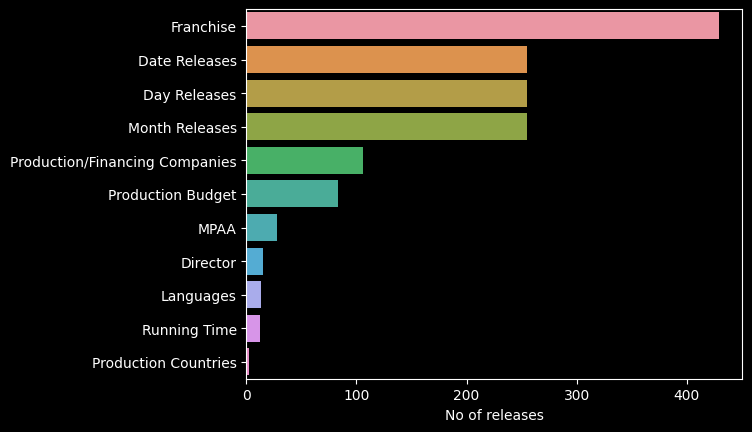

In [1365]:
# plt.figure(figsize=(10,10))
missing=data.isna().sum().sort_values(ascending=False)
sns.barplot(x=missing[:11],y=missing[:11].index)
plt.style.use('dark_background')
plt.xlabel('No of releases')
plt.show()

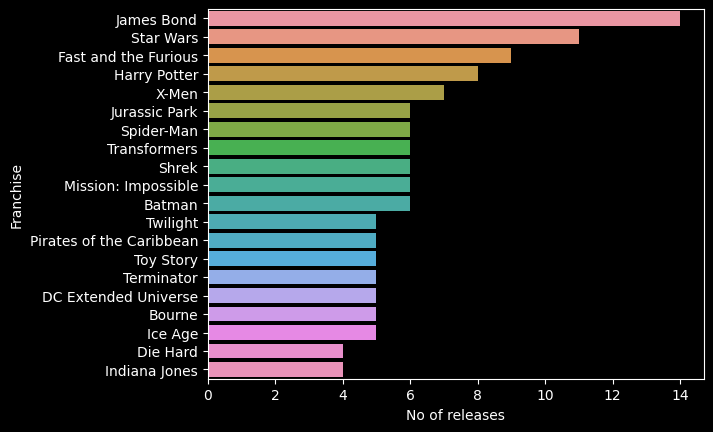

In [1366]:
list_franchise=data.groupby(['Franchise']).size().reset_index(name='No of releases').sort_values(ascending=False,by='No of releases')
sns.barplot(data=list_franchise[:20],y='Franchise',x='No of releases')
plt.show()

<Axes: xlabel='No of releases', ylabel='Production/Financing Companies'>

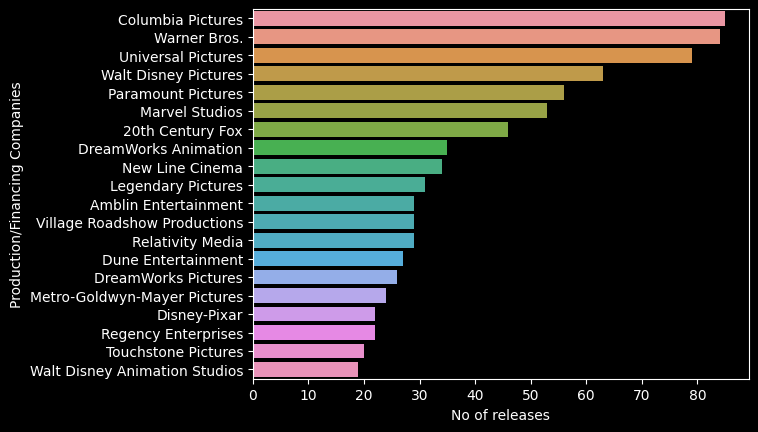

In [1367]:
data['Production/Financing Companies']=data['Production/Financing Companies'].apply(lambda x:[i for i in x.split(', ')] if x is not np.nan else [] )
list_companies=pd.DataFrame(Counter([i for j in data['Production/Financing Companies'] for i in j]).most_common(),columns=['Production/Financing Companies','No of releases'])
sns.barplot(data=list_companies[:20],y='Production/Financing Companies',x='No of releases')

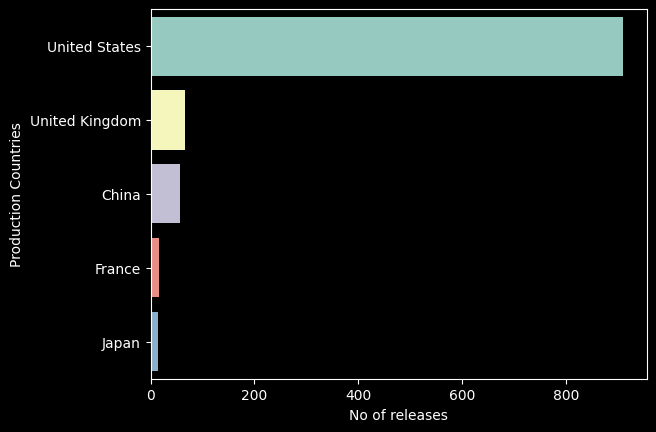

In [1368]:
data['Production Countries']=data['Production Countries'].apply(lambda x:[i for i in x.split(', ')] if x is not np.nan else [] )
list_countries=pd.DataFrame(Counter([i for j in data['Production Countries'] for i in j]).most_common(),columns=['Production Countries','No of releases'])
sns.barplot(data=list_countries[:5],y='Production Countries',x='No of releases')
plt.show()

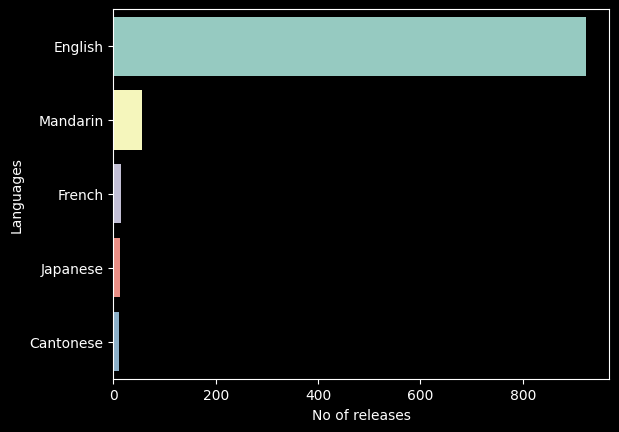

In [1369]:
data['Languages']=data['Languages'].apply(lambda x:[i for i in x.split(', ')] if x is not np.nan else [] )
list_languages=pd.DataFrame(Counter([i for j in data['Languages'] for i in j]).most_common(),columns=['Languages','No of releases'])
sns.barplot(data=list_languages[:5],y='Languages',x='No of releases')
plt.show()


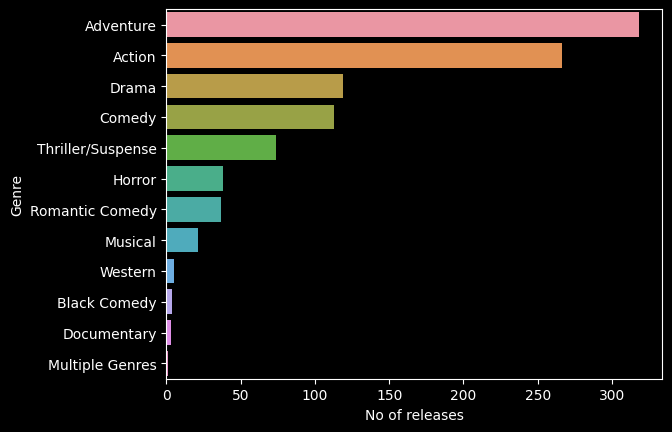

In [1370]:
list_genre=data.groupby(['Genre']).size().reset_index(name='No of releases').sort_values(ascending=False,by='No of releases')
sns.barplot(data=list_genre,y='Genre',x='No of releases')
plt.show()

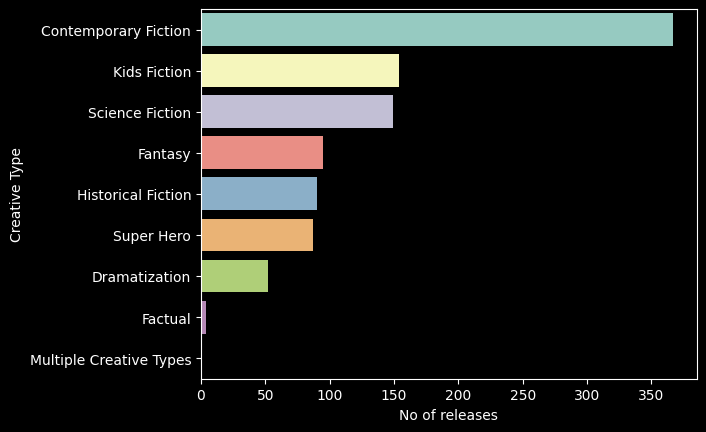

In [1371]:
list_creative_type=data.groupby(['Creative Type']).size().reset_index(name='No of releases').sort_values(ascending=False,by='No of releases')
sns.barplot(data=list_creative_type,y='Creative Type',x='No of releases')
plt.show()

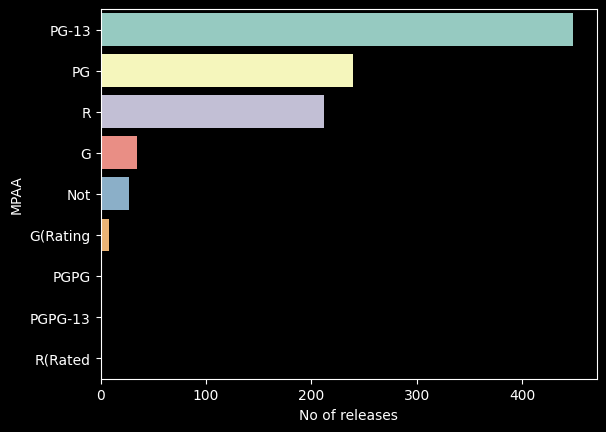

In [1372]:
list_mpaa=data.groupby(['MPAA']).size().reset_index(name='No of releases').sort_values(ascending=False,by='No of releases')
sns.barplot(data=list_mpaa,y='MPAA',x='No of releases')
plt.show()

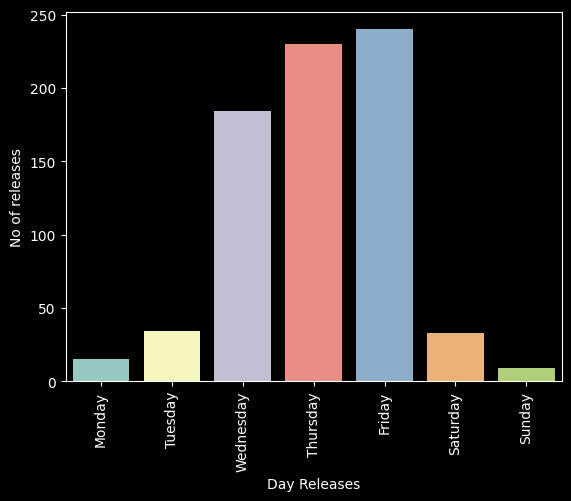

In [1373]:
list_day=data.groupby(['Day Releases']).size().reset_index(name='No of releases')
sns.barplot(data=list_day,x='Day Releases',y='No of releases')
plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation='vertical')
plt.show()

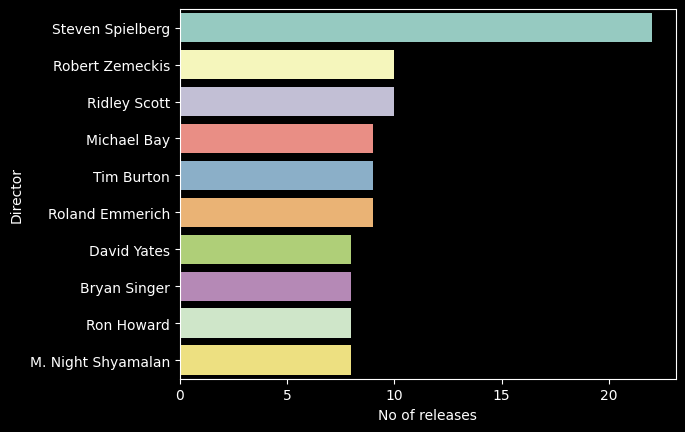

In [1374]:
data['Director']=data['Director'].apply(lambda x:[i for i in x.split(',')] if x is not np.nan else [] )
list_director=pd.DataFrame(Counter([i for j in data['Director'] for i in j]).most_common(),columns=['Director','No of releases'])
sns.barplot(data=list_director[:10],y='Director',x='No of releases')
plt.show()

In [1380]:

X = data.copy()
y =data[['WorldwideBox Office']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [1381]:

def total_revenue(df,var,list):
    list_total=[]
    for i in list[var]:
        total=0
        for j in df.index:
            if df.loc[j,var] is np.nan:
                total+=0
            else:
                total+=df.loc[j,'WorldwideBox Office'] if (i in df.loc[j,var]) else 0
        list_total.append(total)   
    list['WorldwideBox Office']=list_total
    return list.sort_values(by='WorldwideBox Office',ascending=False)


In [1382]:
list_companies=total_revenue(X_train,'Production/Financing Companies',list_companies)
list_countries=total_revenue(X_train,'Production Countries',list_countries)
list_creative_type=total_revenue(X_train,'Creative Type',list_creative_type)
list_director=total_revenue(X_train,'Director',list_director)
list_franchise=total_revenue(X_train,'Franchise',list_franchise)
list_genre=total_revenue(X_train,'Genre',list_genre)
list_languages=total_revenue(X_train,'Languages',list_languages)
list_mpaa=total_revenue(X_train,'MPAA',list_mpaa)

top100_companies=list_companies[:100].copy()
top100_director=list_director[:100].copy()

top15_franchise=list_franchise[:15].copy()


## Trực quan hóa mối quan hệ giữa doanh thu và các đặc trưng huấn luyện

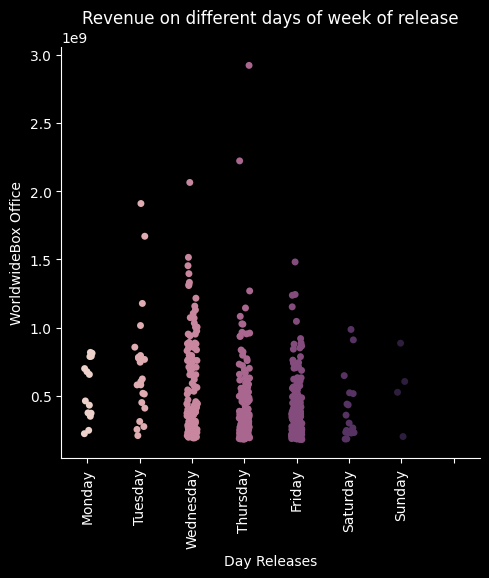

In [1383]:
# plt.figure(figsize=(10,10))
sns.catplot(x=X_train['Day Releases'],y=y_train['WorldwideBox Office'], hue=X_train['Day Releases'])
plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation='vertical')
plt.title('Revenue on different days of week of release')
plt.show()

In [1384]:
# y_train['WorldwideBox Office']=np.log1p(y_train['WorldwideBox Office'])
# X_train['Production Budget']=np.log1p(X_train['Production Budget'])

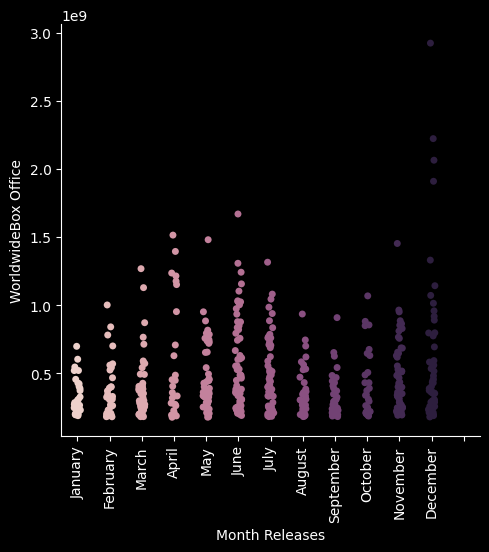

In [1385]:
sns.catplot(x=X_train['Month Releases'],y=y_train['WorldwideBox Office'], hue=X_train['Month Releases'])
plt.gca().set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December'],rotation='vertical')
plt.show()

In [1386]:

# plt.figure(figsize=(15,8))
# yearly=y_train.groupby(X_train['Year'])['WorldwideBox Office'].agg('mean')
# plt.plot(yearly.index,yearly)
# plt.xlabel('year')
# plt.ylabel("WorldwideBox Office")
# plt.savefig('fig')

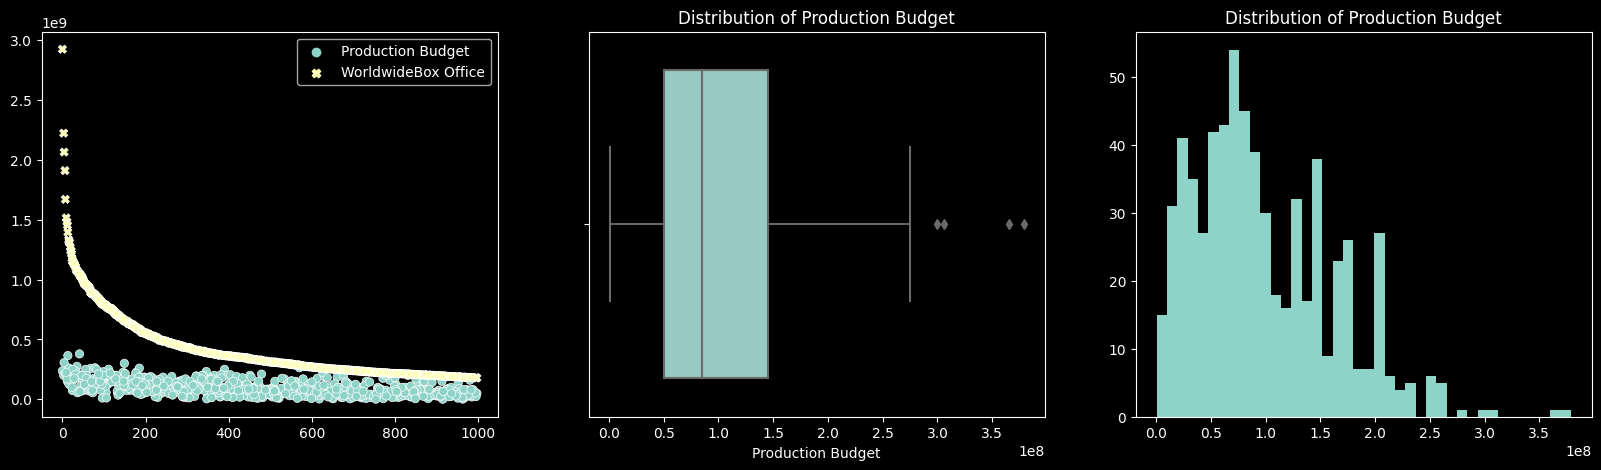

In [1387]:

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.scatterplot(data=[X_train['Production Budget'],y_train['WorldwideBox Office']])
plt.subplot(1,3,2)
sns.boxplot(data=X_train,x='Production Budget')
plt.title('Distribution of Production Budget')
plt.subplot(1, 3, 3)
plt.hist(X_train['Production Budget'], bins=40)
plt.title('Distribution of Production Budget')
plt.show()


Text(0.5, 1.0, 'Running Time vs WorldwideBox Office')

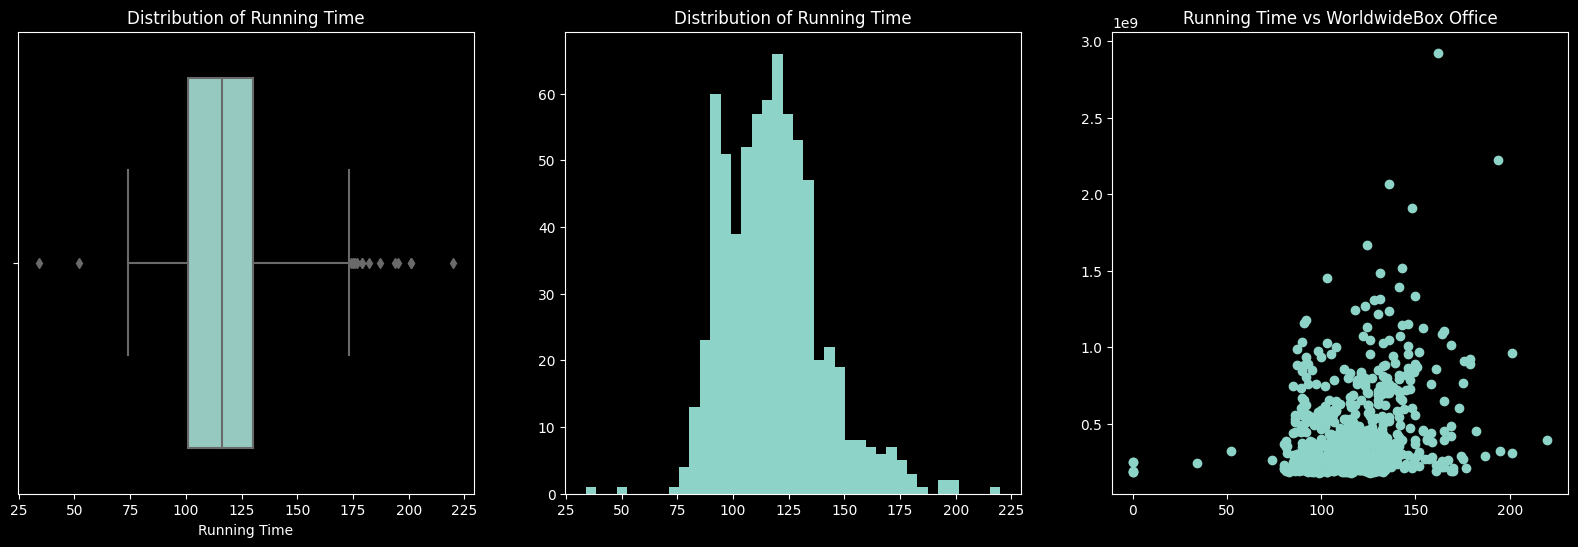

In [1388]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.boxplot(data=X_train,x='Running Time')
plt.title('Distribution of Running Time')
plt.subplot(1, 3, 2)
plt.hist(X_train['Running Time'], bins=40)
plt.title('Distribution of Running Time')
plt.subplot(1, 3, 3)
plt.scatter(X_train['Running Time'].fillna(0), X_train['WorldwideBox Office'])
plt.title('Running Time vs WorldwideBox Office')

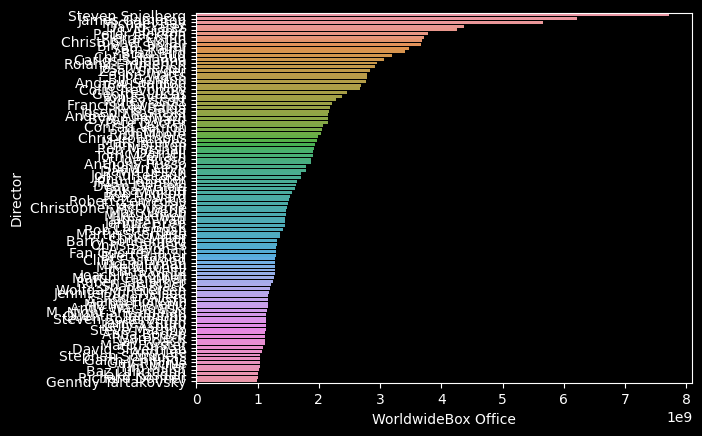

In [1389]:
sns.barplot(data=list_director[:100],y='Director',x='WorldwideBox Office')
plt.show()

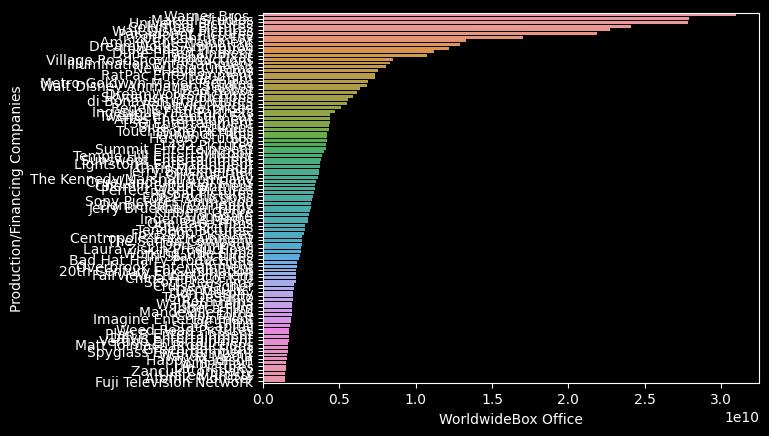

In [1390]:
sns.barplot(data=list_companies[:100],y='Production/Financing Companies',x='WorldwideBox Office')
plt.show()

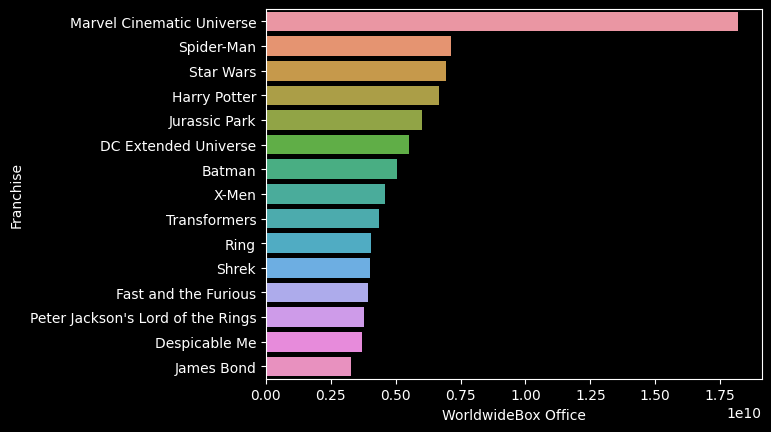

In [1391]:
sns.barplot(data=list_franchise[:15],y='Franchise',x='WorldwideBox Office')
plt.show()

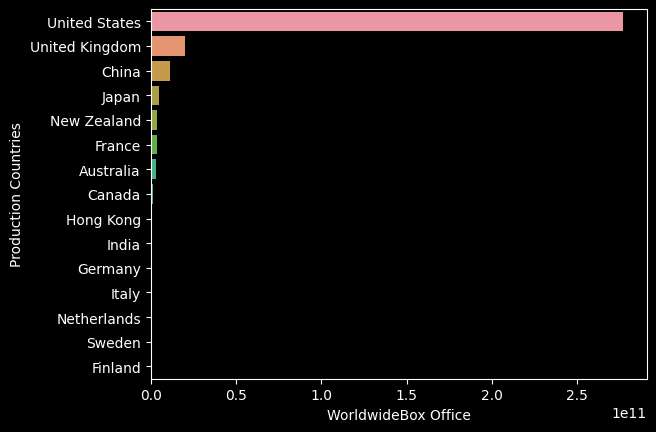

In [1392]:
sns.barplot(data=list_countries[:15],y='Production Countries',x='WorldwideBox Office')
plt.show()

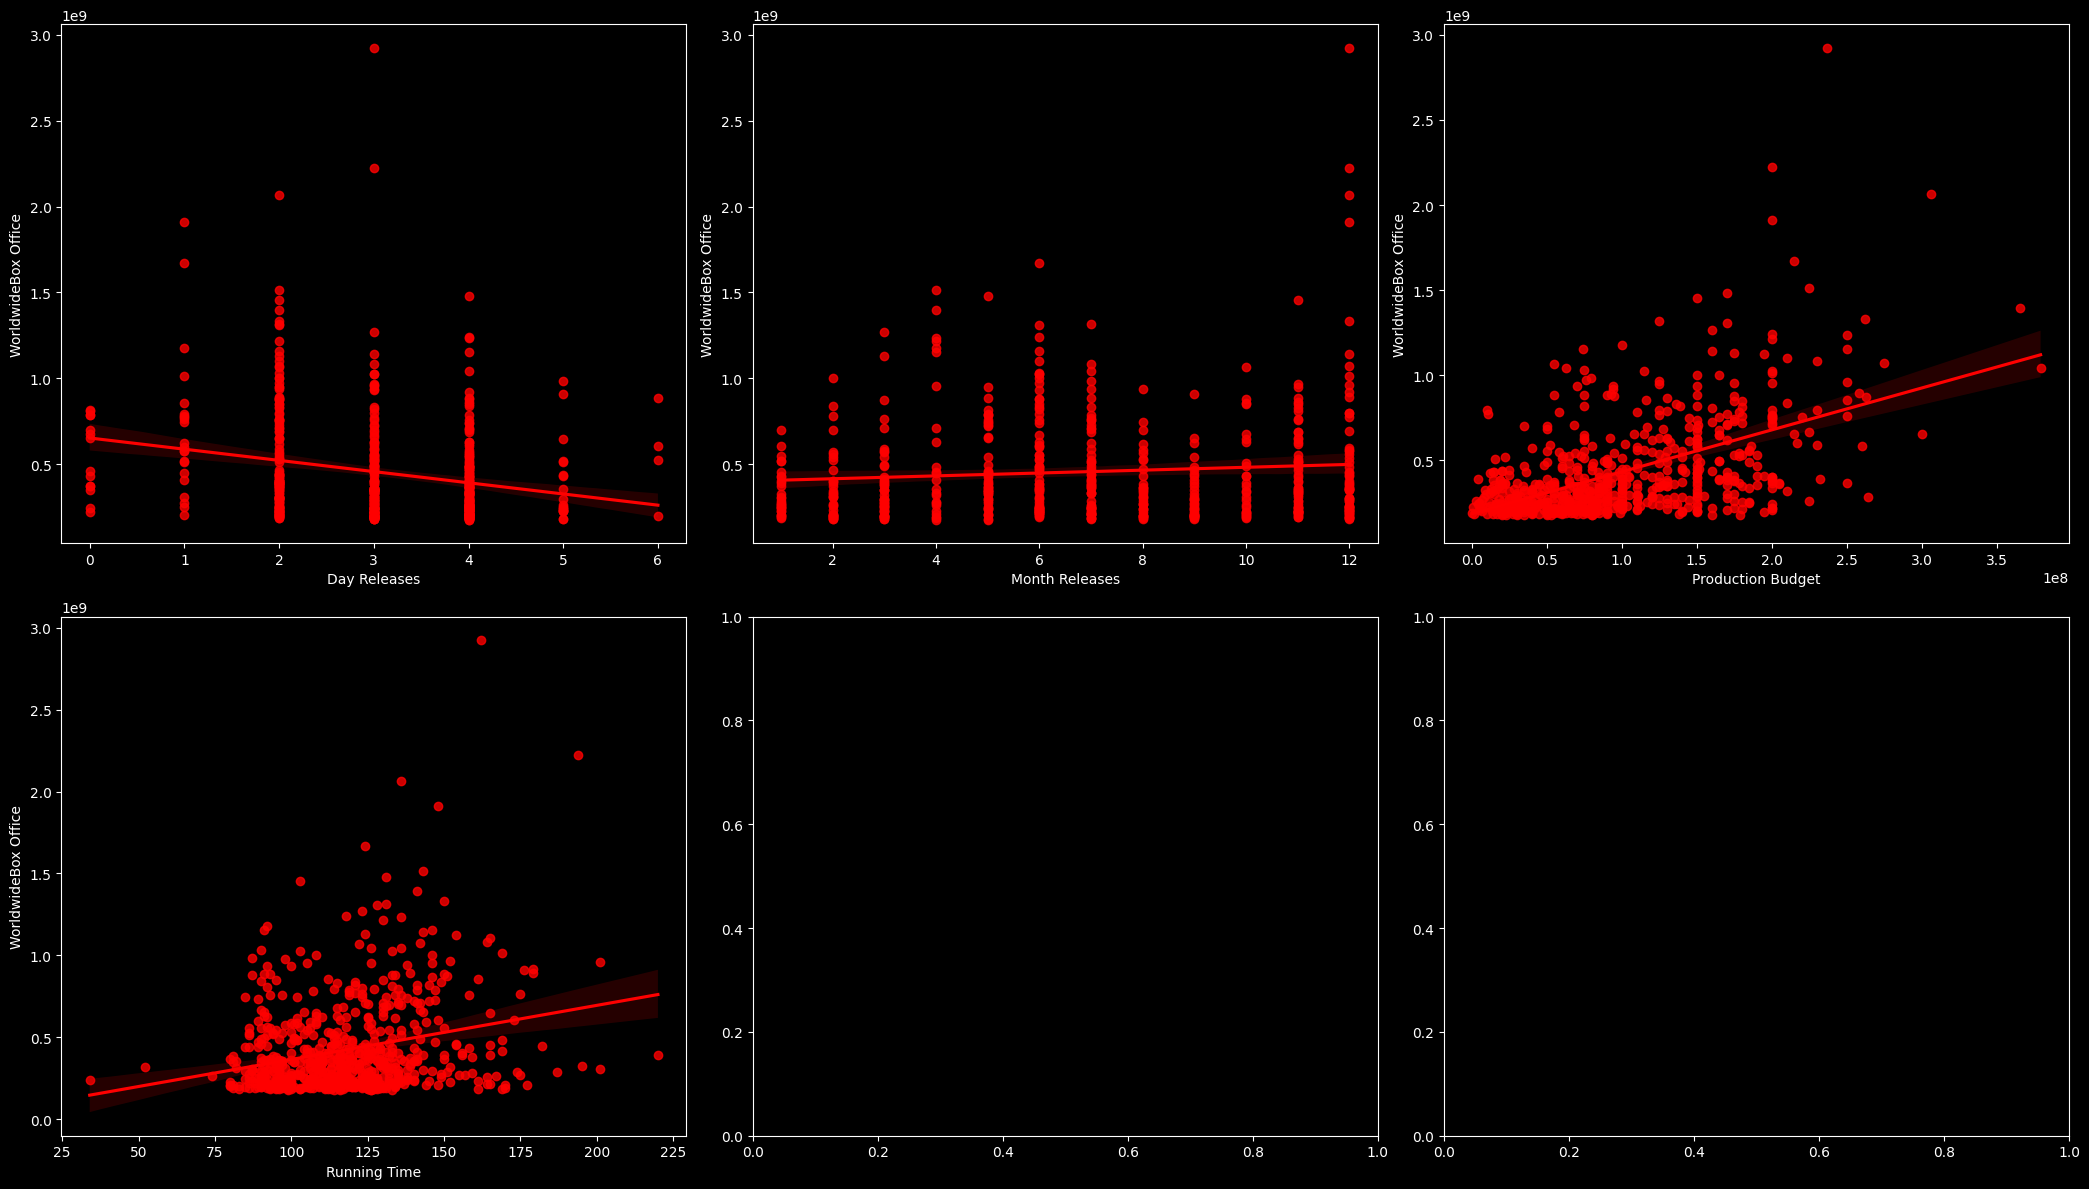

In [1393]:
fig, ax = plt.subplots(2, 3, figsize=(21,12))

ax1 = plt.subplot(231)
ax1 = sns.regplot(data=X_train, y='WorldwideBox Office', x='Day Releases', color='red')
ax2 = plt.subplot(232)
ax2 = sns.regplot(data=X_train, y='WorldwideBox Office', x='Month Releases', color='red')
ax3 = plt.subplot(233)
ax3 = sns.regplot(data=X_train, y='WorldwideBox Office', x='Production Budget', color='red')
ax4 = plt.subplot(234)
ax4 = sns.regplot(data=X_train, y='WorldwideBox Office', x='Running Time', color='red')

plt.tight_layout()

In [1394]:

def is_holiday_month(df):
    df['holiday_month']=[1 if i in [5,6,7,11,12] else np.nan if i is np.nan else 0 for i in df['Month Releases']]
    return df

def original_isEnglish(df):
    df['origin_isEnglish']=[1 if 'English' in i else 0 for i in df['Languages']]
    return df 

def countries_isUS(df):
    df['countries_isUS']=[1 if 'United States' in i else 0 for i in df['Production Countries']]
    return df

def top_companies(df):
    list=[]
    for i in df['Production/Financing Companies']:
        val=1 if any(x in i for x in top100_companies['Production/Financing Companies']) else np.nan if i is np.nan else 0
        list.append(val)
    df['topCompanies']=list
    return df

def isTop_director(df):
    list=[]
    for i in df['Director']:
        val=1 if any(x in i for x in top100_director['Director']) else np.nan if i is np.nan else 0
        list.append(val)
    df['topDirector']=list
    return df

def top_franchise(df):
    list=[]
    for i in df['Franchise']:
        val=1 if  i in top15_franchise['Franchise'] else 0 if i is np.nan else 2
        list.append(val)
    df['topFranchise']=list
    return df


# Mô hình hóa 

## Small Dataset

In [1375]:
metrics_dict_randomforest = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': []
}
metrics_dict_logistic = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': []
}

In [1376]:

def evaluate_params_randomforest(X_train,y_train):
    classifier = RandomForestClassifier()
    # Định nghĩa danh sách các siêu tham số và phân phối tương ứng
    param_dist = {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 5, 10],
        'min_samples_split': uniform(loc=0, scale=1),
        'min_samples_leaf': uniform(loc=0, scale=0.5)
    }
    random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_dist, n_iter=10, cv=5)
    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    print("Best Parameters: ", random_search.best_params_)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    # print(accuracy)
    return best_params


In [1377]:

def evaluate_model_randomforest(X_train, y_train, X_test, y_test):
    print("\n")
    print("Result Randomforest")
    best_param_randomforest = evaluate_params_randomforest(X_train,y_train)
    n_param = best_param_randomforest['n_estimators']
    md_param = best_param_randomforest['max_depth']
    mss_param = best_param_randomforest['min_samples_split']
    msl_param = best_param_randomforest['min_samples_leaf']

    # classifier = RandomForestClassifier()
    classifier = RandomForestClassifier(n_estimators=n_param,max_depth= md_param,min_samples_split=mss_param,min_samples_leaf=msl_param)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    metrics_dict_randomforest['Accuracy'].append(accuracy_score(y_test, y_pred))
    metrics_dict_randomforest['Precision'].append(precision_score(y_test, y_pred, average='macro'))
    metrics_dict_randomforest['Recall'].append(recall_score(y_test, y_pred, average='macro'))
    metrics_dict_randomforest['F1-score'].append(f1_score(y_test, y_pred, average='macro'))
    # print("Accuracy:", accuracy_score(y_test, y_pred))
    # print("Precision:", precision_score(y_test, y_pred, average='macro'))
    # print("Recall:", recall_score(y_test, y_pred, average='macro'))
    # print("F1-score:", f1_score(y_test, y_pred, average='macro'))
    return metrics_dict_randomforest,y_pred



In [1378]:
def evaluate_params_logistic(X_train, y_train):
    classifier = LogisticRegression()
    # Định nghĩa danh sách các siêu tham số và phân phối tương ứng
    param_dist = {
        'C': uniform(loc=0, scale=4),  # Tham số regularization C
        'penalty': ['l1', 'l2'],  # Loại regularization penalty
        'solver': ['liblinear', 'saga']  # Thuật toán tối ưu hóa
    }
    random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_dist, n_iter=10, cv=5)
    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    print("Best Parameters: ", random_search.best_params_)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    # print(accuracy)
    return best_params


In [1379]:

def evaluate_model_logistic(X_train, y_train, X_test, y_test):
    print("\n")
    print("Result Logistic")
    best_param_logistic = evaluate_params_logistic(X_train, y_train)
    C_param = best_param_logistic['C']
    penalty_param = best_param_logistic['penalty']
    solver_param = best_param_logistic['solver']
    classifier = LogisticRegression(C=C_param,penalty=penalty_param,solver=solver_param)
    # classifier = LogisticRegression()

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    metrics_dict_logistic['Accuracy'].append(accuracy_score(y_test, y_pred))
    metrics_dict_logistic['Precision'].append(precision_score(y_test, y_pred, average='weighted'))
    metrics_dict_logistic['Recall'].append(recall_score(y_test, y_pred, average='weighted'))
    metrics_dict_logistic['F1-score'].append(f1_score(y_test, y_pred, average='weighted'))
    # print("Accuracy:", accuracy_score(y_test, y_pred))
    # print("Precision:", precision_score(y_test, y_pred, average='weighted'))
    # print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    # print("F1-score:", f1_score(y_test, y_pred, average='weighted'))

    return metrics_dict_logistic,y_pred

In [1395]:
X_train=top_companies(X_train)
X_train=isTop_director(X_train)
X_train=is_holiday_month(X_train)
X_train=original_isEnglish(X_train)
X_train=top_franchise(X_train)
X_train=countries_isUS(X_train)

X_test=top_companies(X_test)
X_test=isTop_director(X_test)
X_test=is_holiday_month(X_test)
X_test=original_isEnglish(X_test)
X_test=top_franchise(X_test)
X_test=countries_isUS(X_test)


In [1396]:

X_train, X_test = ms_mode(X_train, X_test, 'Running Time')
# X_train, X_test = ms_mode(X_train, X_test, 'Director')
# X_train, X_test = ms_mode(X_train, X_test, 'Production/Financing Companies')
X_train, X_test = ms_mode(X_train, X_test, 'Genre')
X_train, X_test = ms_mode(X_train,X_test,'Production Budget')
# X_train, X_test = ms_mode(X_train,X_test,'Production Countries')
# X_train, X_test = ms_mode(X_train,X_test,'Languages')
X_train, X_test = ms_mode(X_train,X_test,'Creative Type')
X_train, X_test = ms_mode(X_train,X_test,'Day Releases')
X_train, X_test = ms_mode(X_train,X_test,'Month Releases')
X_train,X_test=ms_mode(X_train,X_test,'MPAA')

In [1397]:
X_train = label_encoder(X_train, "Genre")
# X_train = binary_encoder(X_train, "Production/Financing Companies",list_companies)
# X_train = binary_encoder(X_train, "Director",list_director)
X_train = label_encoder(X_train, "Creative Type")
# X_train = binary_encoder(X_train, "Production Countries",list_countries)
X_train=label_encoder(X_train,"MPAA")

X_test = label_encoder(X_test, "Genre")
# X_test = binary_encoder(X_test, "Production/Financing Companies",list_companies)
# X_test = binary_encoder(X_test, "Director",list_director)
X_test = label_encoder(X_test, "Creative Type")
# X_test = binary_encoder(X_test, "Production Countries",list_countries)
X_test=label_encoder(X_test,"MPAA")



In [1398]:
X_train=X_train[['Production Budget','MPAA','Running Time','Genre','Creative Type','topCompanies','topDirector','Day Releases','Month Releases','holiday_month','origin_isEnglish','topFranchise','countries_isUS']]
X_test=X_test[['Production Budget','MPAA','Running Time','Genre','Creative Type','topCompanies','topDirector','Day Releases','Month Releases','holiday_month','origin_isEnglish','topFranchise','countries_isUS']]
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 105 to 684
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Production Budget  700 non-null    float64
 1   MPAA               700 non-null    int64  
 2   Running Time       700 non-null    float64
 3   Genre              700 non-null    int64  
 4   Creative Type      700 non-null    int64  
 5   topCompanies       700 non-null    int64  
 6   topDirector        700 non-null    int64  
 7   Day Releases       700 non-null    float64
 8   Month Releases     700 non-null    float64
 9   holiday_month      700 non-null    int64  
 10  origin_isEnglish   700 non-null    int64  
 11  topFranchise       700 non-null    int64  
 12  countries_isUS     700 non-null    int64  
dtypes: float64(4), int64(9)
memory usage: 92.7 KB


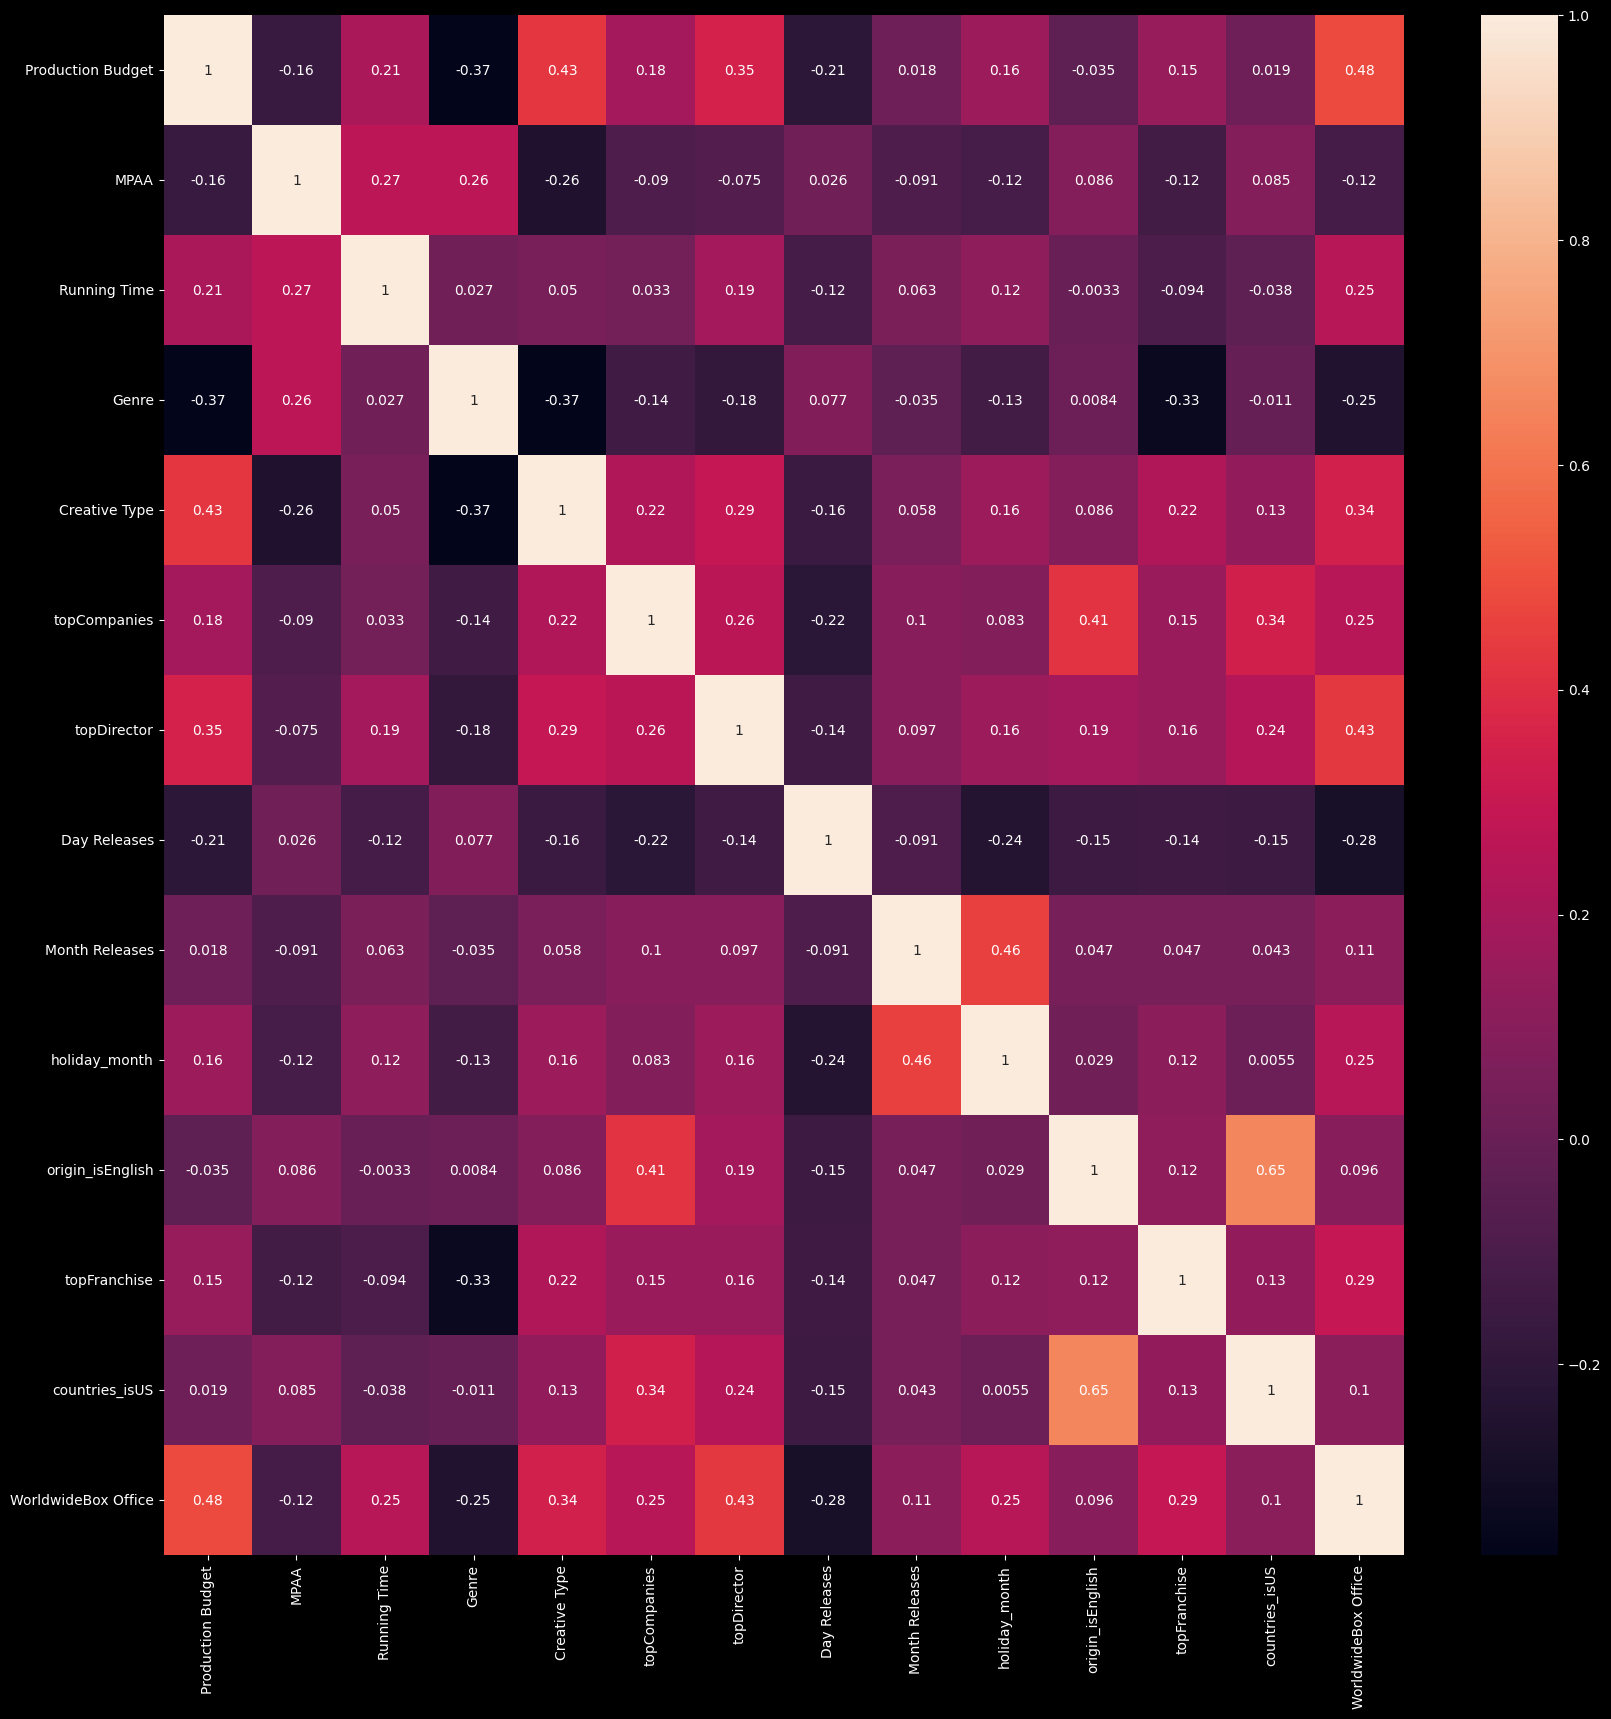

In [1400]:
corr=pd.concat([X_train,y_train],axis=1).corr()
plt.figure(figsize=(20, 20))

# plot heatmap
sns.heatmap(corr, annot=True)
plt.show()

In [1401]:
corr['WorldwideBox Office'].sort_values(ascending=False)

WorldwideBox Office    1.000000
Production Budget      0.484951
topDirector            0.430321
Creative Type          0.343442
topFranchise           0.291902
topCompanies           0.250068
Running Time           0.249773
holiday_month          0.246166
Month Releases         0.111579
countries_isUS         0.104988
origin_isEnglish       0.096471
MPAA                  -0.118873
Genre                 -0.252266
Day Releases          -0.280336
Name: WorldwideBox Office, dtype: float64

In [1402]:

X_train,X_test = handler_outlier(X_train,X_test,'Running Time')
X_train,X_test = handler_outlier(X_train,X_test,'Production Budget')

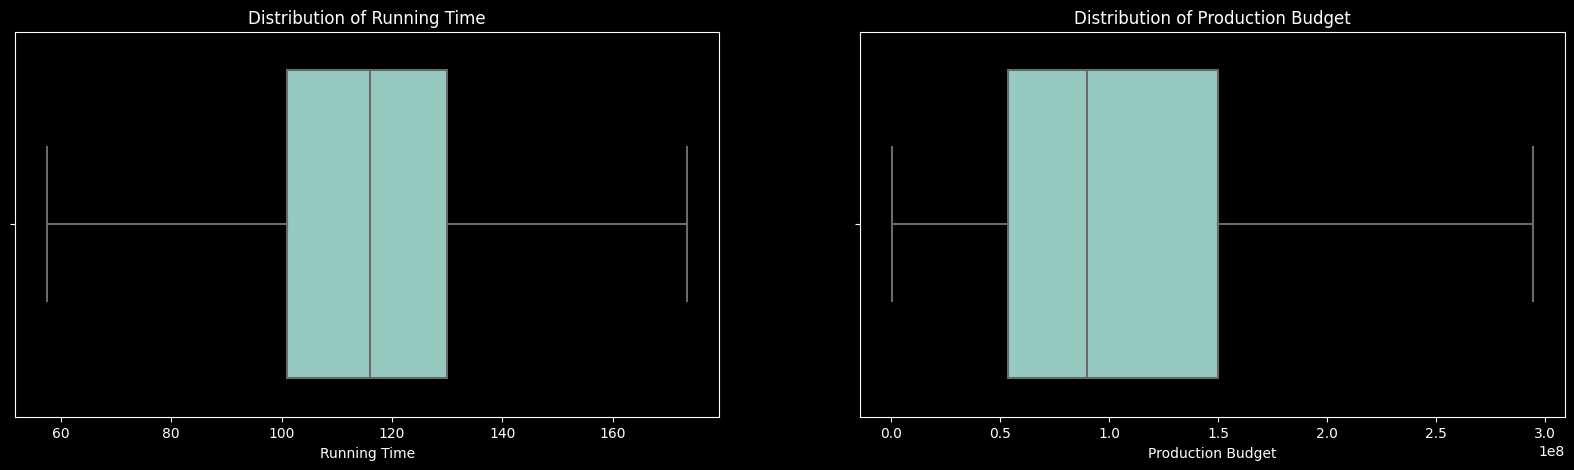

In [1403]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=X_train,x='Running Time')
plt.title('Distribution of Running Time')
plt.subplot(1, 2, 2)
sns.boxplot(data=X_train,x='Production Budget')
plt.title('Distribution of Production Budget')
plt.show()

In [1404]:
# bin_edges = [0, 400000000, 800000000, 1200000000, 1600000000, 2000000000, 2400000000,
#              2800000000, 3200000000]
# bin_labels = [0, 1, 2, 3, 4, 5, 6, 7]
# bin_edges = [0, 200000000, 400000000, 600000000, 800000000, 1000000000, 1200000000,
#              1400000000, 1600000000,1800000000,2000000000,2200000000,2400000000,2600000000,2800000000,3000000000,3200000000]
# bin_labels = [0, 1, 2, 3, 4, 5, 6, 7,8,9,10,11,12,13,14,15]
# bin_edges = [0, 300000000, 600000000, 900000000, 1200000000, 15000000000, 1800000000,
#              2100000000, 2400000000,2700000000,3000000000]
bin_edges=[x for x in range(0,3000000001,300000000)]
bin_labels = [x for x in range(1,len(bin_edges))]

y_train_val = pd.cut(y_train['WorldwideBox Office'], bins=bin_edges, labels=bin_labels)
y_test_val = pd.cut(y_test['WorldwideBox Office'], bins=bin_edges, labels=bin_labels)

# metrics_dict=evaluate_model_logistic(X_train,y_train_val,X_test,y_test_val)

y_train.to_csv('encoded_data.csv', index=False)
metrics_dict_logistic,_=evaluate_model_logistic(X_train,y_train_val,X_test,y_test_val)
metrics_dict_randomforest,_=evaluate_model_randomforest(X_train,y_train_val,X_test,y_test_val)


normal_list = ['Unscaled', 'Standard', 'MinMax', 'MaxAbs', 'Robust', 'PowerTransformer',
               'Normalizer']

# for i in normal_list[1]:
X_train_val, X_test_val = normal_data(X_train, X_test, 'Standard')
metrics_dict_logistic,_=evaluate_model_logistic(X_train_val,y_train_val,X_test_val,y_test_val)
metrics_dict_randomforest,_=evaluate_model_randomforest(X_train_val,y_train_val,X_test_val,y_test_val)


k = 7  # Số lượng đặc trưng tốt nhất bạn muốn chọn
selector = SelectKBest(score_func=f_regression, k=k)
selected_features = selector.fit_transform(X_train_val, y_train_val)
feature_indices = selector.get_support(indices=True)
selected_feature_names = X_train_val.columns[feature_indices]
print(selected_feature_names)
X_train_val = X_train_val[selected_feature_names]

# classifier = RandomForestClassifier()
# classifier.fit(X_train_val, y_train_val)
# y_pred = classifier.predict(X_test_val[selected_feature_names])
# print(i)
# accuracy = accuracy_score(y_test_val, y_pred)
# precision = precision_score(y_test_val, y_pred, average='macro')
# recall = recall_score(y_test_val, y_pred, average='macro')
# f1 = f1_score(y_test_val, y_pred, average='macro')

# print('Accuracy:', accuracy)
# print('Precision:', precision)
# print('Recall:', recall)
# print('F1-score:', f1)
metrics_dict_logistic,y_pred_logistic=evaluate_model_logistic(X_train_val,y_train_val,X_test_val[selected_feature_names],y_test_val)
metrics_dict_randomforest,y_pred_randomforest=evaluate_model_randomforest(X_train_val,y_train_val,X_test_val[selected_feature_names],y_test_val)




Result Logistic
Best Parameters:  {'C': 0.7011970790620521, 'penalty': 'l1', 'solver': 'liblinear'}


Result Randomforest
Best Parameters:  {'max_depth': None, 'min_samples_leaf': 0.08695289421485697, 'min_samples_split': 0.19584416747017952, 'n_estimators': 50}


Result Logistic
Best Parameters:  {'C': 0.37042052715522944, 'penalty': 'l2', 'solver': 'saga'}


Result Randomforest
Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 0.10764690726593962, 'min_samples_split': 0.23954375031236486, 'n_estimators': 10}
Index(['Production Budget', 'Genre', 'Creative Type', 'topCompanies',
       'topDirector', 'Day Releases', 'topFranchise'],
      dtype='object')


Result Logistic
Best Parameters:  {'C': 1.8413680304127666, 'penalty': 'l1', 'solver': 'liblinear'}


Result Randomforest
Best Parameters:  {'max_depth': None, 'min_samples_leaf': 0.1256331103604385, 'min_samples_split': 0.2805414704636412, 'n_estimators': 50}


In [1405]:

metrics_dict_logistic=pd.DataFrame(metrics_dict_logistic,index=['Outlier','Standard','SelectKBest'])
metrics_dict_logistic

,Accuracy,Precision,Recall,F1-score
Outlier,0.593333,0.513710,0.593333,0.532991
Standard,0.606667,0.581959,0.606667,0.592468
SelectKBest,0.613333,0.551845,0.613333,0.577135


In [1406]:
metrics_dict_randomforest=pd.DataFrame(metrics_dict_randomforest,index=['Outlier','Standard','SelectKBest'])
metrics_dict_randomforest


,Accuracy,Precision,Recall,F1-score
Outlier,0.570000,0.119874,0.139285,0.121892
Standard,0.576667,0.123839,0.140828,0.123154
SelectKBest,0.570000,0.119444,0.138597,0.119863


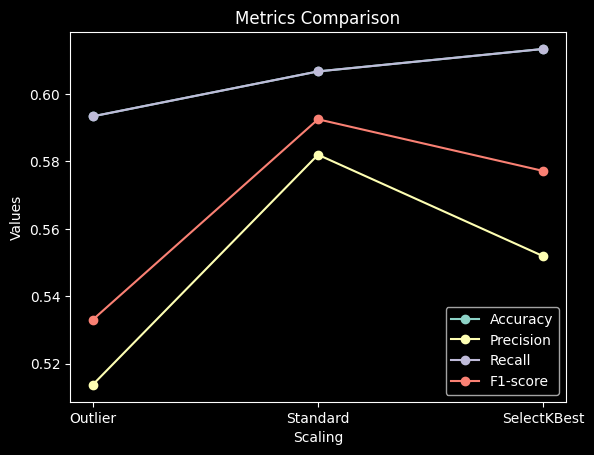

In [1407]:
metrics = list(metrics_dict_logistic.keys())

for metric in metrics:
    values = metrics_dict_logistic[metric]
    plt.plot(['Outlier','Standard','SelectKBest'], values, marker='o', label=metric)



plt.title('Metrics Comparison')
plt.xlabel('Scaling')
plt.ylabel('Values')
plt.legend()
plt.show()

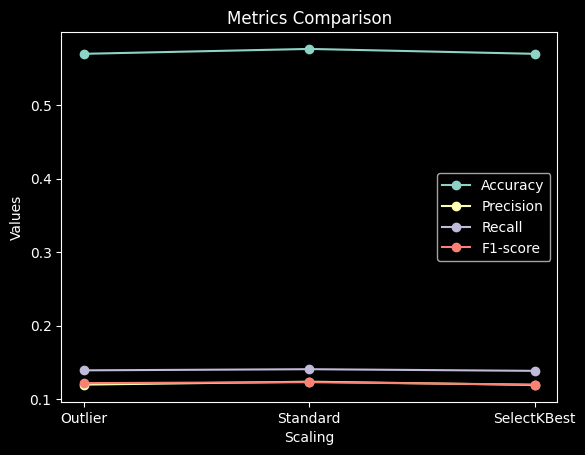

In [1408]:
metrics = list(metrics_dict_randomforest.keys())

for metric in metrics:
    values = metrics_dict_randomforest[metric]
    plt.plot(['Outlier','Standard','SelectKBest'], values, marker='o', label=metric)



plt.title('Metrics Comparison')
plt.xlabel('Scaling')
plt.ylabel('Values')
plt.legend()
plt.show()

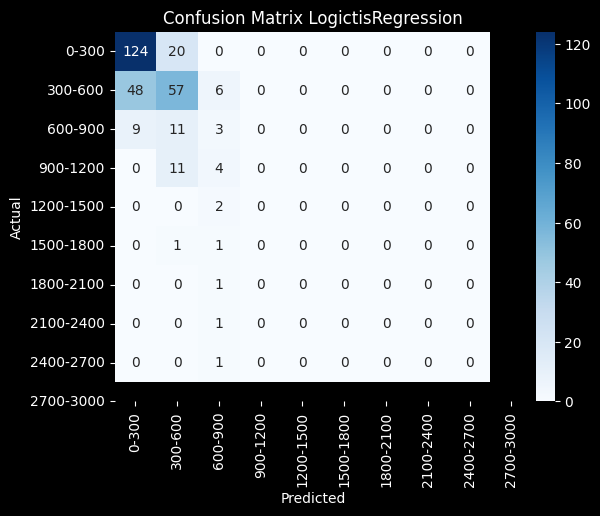

In [1409]:
labels=['0-300','300-600','600-900','900-1200','1200-1500','1500-1800','1800-2100','2100-2400','2400-2700','2700-3000']
cm_logictis=confusion_matrix(np.array(y_test_val),y_pred_logistic)
sns.heatmap(cm_logictis, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.title('Confusion Matrix LogictisRegression')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

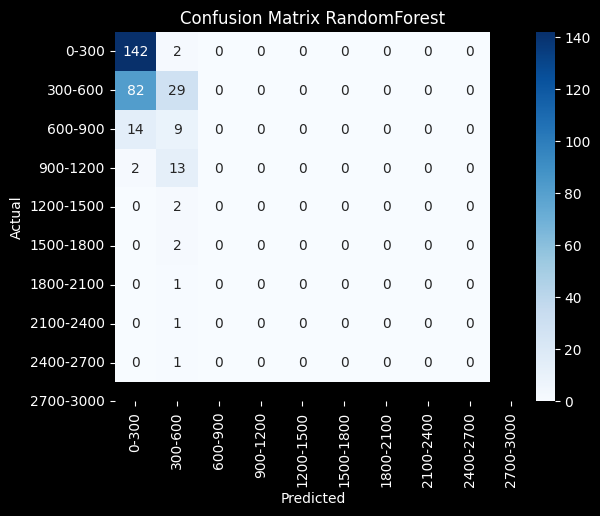

In [1410]:
cm_logictis=confusion_matrix(np.array(y_test_val),y_pred_randomforest)
sns.heatmap(cm_logictis, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.title('Confusion Matrix RandomForest')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()